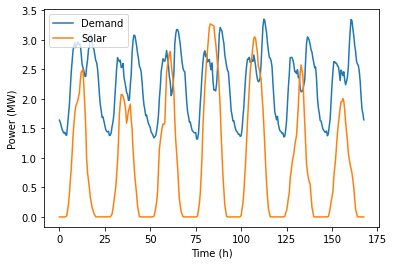

In [36]:
#%%%% Get the week's forecasts for solar and demand, formatted as 7 x array(size=48) each!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#these excel sheets have one title row, then begin at 00:00 of the the first day of the week through to 23:30 on the last day (7 days total)
#the first column is the timeseries, the second column is the PV/Demand data in MW
df = pd.read_excel (r'/Users/cormacomalley/Documents/POD_Challenge/week4-pv-std-new.xlsx') #place "r" before the path string to address special character, such as '\'. Don't forget to put the file name at the end of the path + '.xlsx'
WeekSolar=df.to_numpy()[:,1]

df = pd.read_excel (r'/Users/cormacomalley/Documents/POD_Challenge/week4-demand-std.xlsx') #place "r" before the path string to address special character, such as '\'. Don't forget to put the file name at the end of the path + '.xlsx'
WeekDemand=df.to_numpy()[:,1]

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(np.arange(0,168,0.5), WeekDemand,label='Demand')  # Plot Demand forecast
ax.plot(np.arange(0,168,0.5), WeekSolar,label='Solar')  # Plot Solar forecast

ax.legend(loc='upper left')
plt.xlabel("Time (h)")
plt.ylabel("Power (MW)")

#seperate the forecasts into individual days, 0 is Monday, 6 is sunday
DayDemand=np.empty([7,48])
DaySolar=np.empty([7,48])

for d in range(0,7):
    DayDemand[d,:]=WeekDemand[(d*48):(d+1)*48]
    DaySolar[d,:]=WeekSolar[(d*48):(d+1)*48]

Sample Average Approximation: 
$ min \Big( c^T x + \frac{1}{N} \sum^N_{n=1} Q(x,\xi^j) \Big)$

Where the Q is the cost (including recourse) for each realisation of $\xi^n$

The stochastic problem is nonconvex due to the definition of propSolar (i.e. the proportion of Solar charge within the battery), and its subsequent inclusion within the Cost Function.

The deterministic problem is convex, because the proportion of charge from Solar is not explicitly costed, instead a deterministic conservative approach is taken where the charging is confined to be a at most a set proportion of the forecasted solar output (Conservativness_factor_limit).

In [43]:
#set up the PV data as normally distributed, assume original forecast gives the mean value (i.e DaySolar)
#NB, if want to revert to deterministic just make N=1 and s.d. = 0
DaySolarStandardDev=np.empty([7,48])

#assume for now that all the PV outputs have sd = alpha*mean, alternativly could use inferred standard deviations
alpha=0.2
DaySolarStandardDev = alpha*DaySolar

#N is the number of samples per timestep, larger is more accurate but lower tractability
N=300

DaySolarRealisations=np.empty([7,48,N])

#fill in the realisations
for d in range(0,7):
    for k in range(0,48):
        DaySolarRealisations[d,k,:]=np.random.normal(DaySolar[d,k],DaySolarStandardDev[d,k],N)
        
#make any -ve realisations = 0, not perfect but should have minor effect
for d in range (0,7):    
    for k in range(0,48):
        DaySolarRealisations[d,k,:] = [0 if g < 0 else g for g in DaySolarRealisations[d,k,:]]

In [44]:
#%%%% Stochastic Solve %%%%#

import pyomo.environ as pyo
from pyomo.opt import SolverFactory

# Create a solver
opt = pyo.SolverFactory('ipopt')

#create arrays to store variables for each day
B_day_results=np.empty([7,48]) #stores optimal battery charging levels (MW)
C_day_results=np.empty([7,48]) #stores optimal battery charge levels (MWh) (NB C orresponds to charge at the beginning of k timestep)
ReducedDemand=np.empty([7,48]) #the demand net battery discharge (MW)

Day_Peak_Reduction=np.empty([7]) #stores the peak reduction percentage (%)
WeightedPeakReduction=np.empty([7]) #stores the final objective value for each day

P_results=np.empty([7,48,N])
Q_results=np.empty([7,N])
propSolar_results=np.empty([7,N])

#Define Cost weightings
C1=3 #the larger C1 is compared to C2, the more advantageous it is to charge from Solar
C2=1

for d in range(0,7):

    #%%%% Create model
    model=pyo.ConcreteModel()  #create the model object, concrete because parameters are known


    #%%%% Declare Indexs
    model.TimeIndex=range(48)  #NB, index for time of day, starts at 0 (referring to period 00:00 - 00:30)
    model.StochasticIndex=range(N) #this refers to the decision variables for each potential day's solar output


    #%%%% Declare Parameters
    #Conservativness_factor_limit = 0.9 #this limits the battery charge as a proportion of solar power (B[k] < Conservativness_factor*DaySolaa[k])

    ChargePeriodEnd = 30 #k index of final half hour time slot where charging is allowed (3:00pm-3:30pm), midnight k=0
    PeakPeriodEnd = 41 #k index of final half hour period of peak demand (8:30pm-9:00pm), midnight k = 0

    MaxBatteryChargeRate = 2.5 #Max charge and discharge rate in MW. Discharge -ive, Charge +ve
    MaxBatteryCapacity = 6 #Max Charge held in battery (MWh)

    #NB this is in MW
    Peak_old = sum(DayDemand[d,k] for k in range(ChargePeriodEnd+1,PeakPeriodEnd+1)) #this is the sum of peak demand with no battery (MW)
    model.Peak_old = pyo.Param(initialize = Peak_old)



    #%%%% Declare decision variables
    model.B=pyo.Var(model.TimeIndex, bounds = (-MaxBatteryChargeRate,MaxBatteryChargeRate)) #charging rate, discharge is -ve, charge is +ve 
    model.C=pyo.Var(model.TimeIndex, bounds = (0,MaxBatteryCapacity)) #this is the battery charge (MWh) at teh Beginning of the time period k
    model.Peak_new=pyo.Var() #sum of peak demand with charging
    model.Peak_reduction_percentage=pyo.Var() #percentage deduction in peak power demand
    #model.conservativness_factor=pyo.Var( bounds = (0,Conservativness_factor_limit)) #assume is uniform over day for now, cannot be larger than Conservativness_factor_limit
    model.conservativness_factor_discharge=pyo.Var( bounds = (0,10)) #want to distribute the discharge evenly across peak period to prevent the 
    
    model.Q=pyo.Var(model.StochasticIndex) #the cost for a days potential solar realisations
    model.propSolar=pyo.Var(model.StochasticIndex, bounds = (0,1)) #the proportion of the battery charged by solar that day (p_{d,1} in POD documentation)
    model.P=pyo.Var(model.TimeIndex,model.StochasticIndex,bounds = (0,2.5)) #amount of chrage into battery from solar at hour k for realisation n (MW)
    
    
    #%%%% Declare constraints
    #prevent battery discharge before peak time
    model.pos_charge_con = pyo.ConstraintList()
    for k in range(0,ChargePeriodEnd+1):   #the +1 is because range does not include the final entry
        model.pos_charge_con.add(model.B[k]>=0)
        
    for k in range(PeakPeriodEnd+1,48):
        model.pos_charge_con.add(model.B[k]>=0)

    #prevent battery charge during from beginning of peak period to end of day (3:30pm-11:59pm)   
    model.neg_charge_con = pyo.ConstraintList()
    for k in range(ChargePeriodEnd+1,48):
        model.neg_charge_con.add(model.B[k]<=0)

    #charge rate determines battery charge
    model.battery_charge_level_con = pyo.ConstraintList()
    for k in range(0,48):
        if k==0:
            #model.battery_charge_level_con.add(model.C[k]==0.5*model.B[k]) #battery starts on zero charge
            model.battery_charge_level_con.add(model.C[k]==0) #battery starts on zero charge
        else:
            model.battery_charge_level_con.add(model.C[k]==model.C[k-1]+0.5*model.B[k-1])

    #battery charge must be zero at the end of the day (here i have constrained it to be zero at 11:30, as any time after peak suffices)
    model.end_of_day_charge = pyo.Constraint(expr = model.C[47] == 0)

    #Work out the new sum of peak demand (MW)
    model.Peak_new_con = pyo.Constraint(expr = model.Peak_new == sum(DayDemand[d,k]+model.B[k] for k in range(ChargePeriodEnd+1,PeakPeriodEnd+1)))
    #Define Peak reduction percentage
    model.Peak_reduction_percentage_con = pyo.Constraint(expr = (model.Peak_old - model.Peak_new)*1/model.Peak_old == model.Peak_reduction_percentage)
    #model.Peak_reduction_percentage_con1 =  pyo.Constraint(expr = model.Peak_reduction_percentage==0.27)

    #%%% Add constraint to make discharge lower than the demand 
    #this spreads discharge evenly over peak period, the factor will approx=peakreductionpercentage/100
    model.solar_discharge_priority_con = pyo.ConstraintList()
    for k in range(ChargePeriodEnd+1,PeakPeriodEnd+1):   #the +1 is because range dis up to the final entry, but not including the final entry
        model.solar_discharge_priority_con.add(-model.B[k]<=model.conservativness_factor_discharge*DayDemand[d,k])



    #%%%% Constraints to Improve Ratio of Solar Power in the Battery
    
    #constrain model.P so that it is less than the solar realisation and at most as large as B[k]
    model.P_less_than_B_con = pyo.ConstraintList()
    model.P_less_than_Solar_con = pyo.ConstraintList()
    for n in range(0,N):
        for k in range(0,ChargePeriodEnd+1):   #the +1 is because range does not include the final entry
            model.P_less_than_B_con.add(model.P[k,n]<=model.B[k])
            model.P_less_than_Solar_con.add(model.P[k,n]<=DaySolarRealisations[d,k,n])
    
    
    #define model.propSolar and the cost function for each stochastic realisation
    model.propSolar_con = pyo.ConstraintList()
    model.Q_con = pyo.ConstraintList()
    for n in range(0,N):
        model.propSolar_con.add(model.propSolar[n]*sum(model.B[k] for k in range(0,ChargePeriodEnd+1))==sum(model.P[k,n] for k in range(0,ChargePeriodEnd+1)))

    #%%%% Declare objective function
    #the conservativness factors are included as a penalty in the objective function to make them be as small as
    #possible without significantly impacting the peak reduction percentage
    model.obj=pyo.Objective(
        expr= 100*((1/N) * (sum(C1*model.propSolar[n]*model.Peak_reduction_percentage for n in range(0,N)) + sum(C2*(1-model.propSolar[n])*model.Peak_reduction_percentage for n in range(0,N))))-0.00001*model.conservativness_factor_discharge,       
        sense=pyo.maximize )


    #%%%% Solve and store variables
    opt.solve(model) 
    
    for k in range(0,48):
        B_day_results[d,k]=pyo.value(model.B[k])
        C_day_results[d,k]=pyo.value(model.C[k])
        
    for n in range(0,N):
        #Q_results[d,n]=pyo.value(model.Q[n])
        propSolar_results[d,n]=pyo.value(model.propSolar[n])        
        
        for k in range(0,ChargePeriodEnd+1):
            P_results[d,k,n]=pyo.value(model.P[k,n])

    WeightedPeakReduction[d]=pyo.value(model.obj)
    
    ReducedDemand[d,0:(ChargePeriodEnd+1)]=DayDemand[d,0:(ChargePeriodEnd+1)]
    ReducedDemand[d,(ChargePeriodEnd+1):48]=DayDemand[d,(ChargePeriodEnd+1):48]+B_day_results[d,(ChargePeriodEnd+1):48]

    Day_Peak_Reduction[d]= pyo.value(model.Peak_reduction_percentage)#stores the peak reduction percentage (%)
    #Charge_Con_Factor[d]= pyo.value(model.conservativness_factor) #stores the optimum Charge Conservativness Factor


#%%%% Display Results
#model.display()

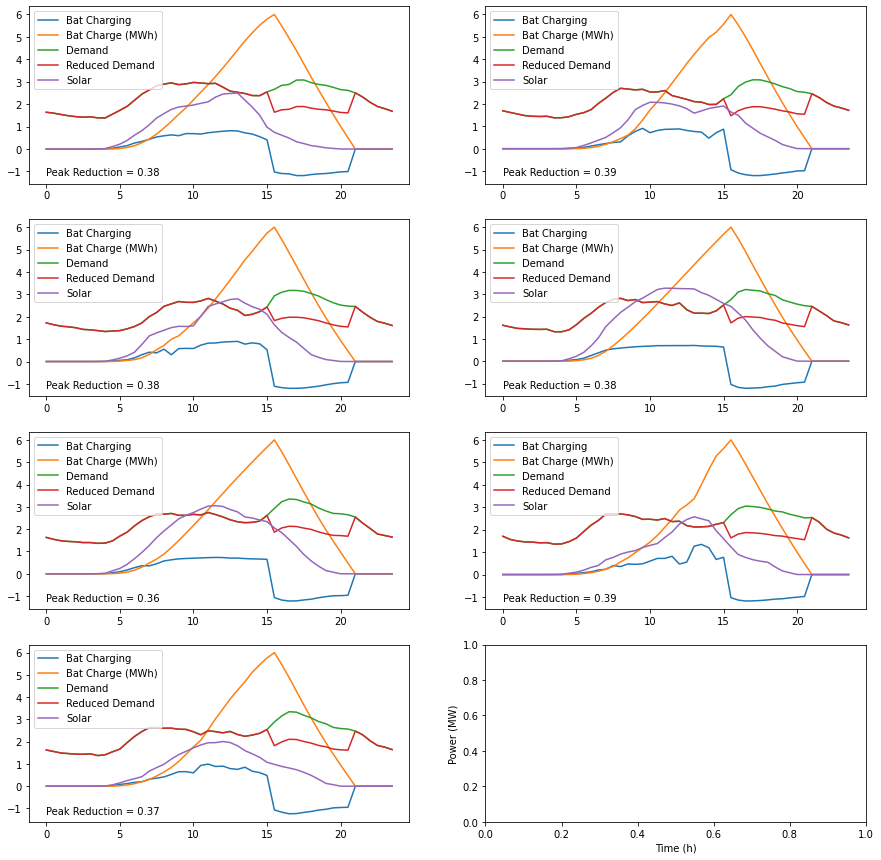

In [45]:
#%%%% Plot Results %%%%#

import matplotlib.pyplot as plt

fig, ax = plt.subplots(4,2)  # Create a figure that has one axes per day

plotcolumn=0
plotrow=0
for d in range(0,7):
    
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), B_day_results[d,:], label='Bat Charging')  # Plot Battery Charging (+ve charge, -ve discharge)
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), C_day_results[d,:], label='Bat Charge (MWh)')  # Plot Battery Charge level (this is the charge at the end of the given timestep)
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), DayDemand[d,:],label='Demand')  # Plot Demand forecast
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), ReducedDemand[d,:],label='Reduced Demand')  # Plot adjusted Demand
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), DaySolar[d,:],label='Solar')  # Plot Solar forecast


    ax[plotrow,plotcolumn].legend(loc='upper left')
    plt.xlabel("Time (h)")
    plt.ylabel("Power (MW)")

    Notation = "Peak Reduction = "+"{:.2f}".format(Day_Peak_Reduction[d])
    ax[plotrow,plotcolumn].annotate(Notation ,(0,min(B_day_results[d,:])))

    #if statements used to arrange the graphs correctly
    if d==1 or d==3 or d==5:
        plotrow += 1
    
    if plotcolumn==0:
        plotcolumn = 1
    else:
        plotcolumn = 0
       

fig.set_figheight(15)
fig.set_figwidth(15)       

In [26]:
#%%%% Deterministic solving of the optimal charging problem, potentially used to initialize the problem %%%%#

import pyomo.environ as pyo
from pyomo.opt import SolverFactory

# Create a solver
opt = pyo.SolverFactory('mosek')

#create arrays to store variables for each day
B_day_results=np.empty([7,48]) #stores optimal battery charging levels (MW)
C_day_results=np.empty([7,48]) #stores optimal battery charge levels (MWh) (NB C orresponds to charge at the beginning of k timestep)
ReducedDemand=np.empty([7,48]) #the demand net battery discharge (MW)

Day_Peak_Reduction=np.empty([7]) #stores the peak reduction percentage (%)
Charge_Con_Factor=np.empty([7]) #stores the optimum Charge Conservativness Factor


for d in range(0,7):

    #%%%% Create model
    model=pyo.ConcreteModel()  #create the model object, concrete because parameters are known


    #%%%% Declare Indexs
    model.TimeIndex=range(48)  #NB, index for time of day, starts at 0 (referring to period 00:00 - 00:30)



    #%%%% Declare Parameters
    Conservativness_factor_limit = 0.7 #this limits the battery charge as a proportion of solar power (B[k] < Conservativness_factor*DaySolaa[k])

    ChargePeriodEnd = 30 #k index of final half hour time slot where charging is allowed (3:00pm-3:30pm), midnight k=0
    PeakPeriodEnd = 41 #k index of final half hour period of peak demand (8:30pm-9:00pm), midnight k = 0

    MaxBatteryChargeRate = 2.5 #Max charge and discharge rate in MW. Discharge -ive, Charge +ve
    MaxBatteryCapacity = 6 #Max Charge held in battery (MWh)

    #NB this is in MW
    Peak_old = sum(DayDemand[d,k] for k in range(ChargePeriodEnd+1,PeakPeriodEnd+1)) #this is the sum of peak demand with no battery (MW)
    model.Peak_old = pyo.Param(initialize = Peak_old)



    #%%%% Declare decision variables
    model.B=pyo.Var(model.TimeIndex, bounds = (-MaxBatteryChargeRate,MaxBatteryChargeRate)) #charging rate, discharge is -ve, charge is +ve 
    model.C=pyo.Var(model.TimeIndex, bounds = (0,MaxBatteryCapacity)) #this is the battery charge (MWh) at teh Beginning of the time period k
    model.Peak_new=pyo.Var() #sum of peak demand with charging
    model.Peak_reduction_percentage=pyo.Var() #percentage deduction in peak power demand
    model.conservativness_factor=pyo.Var( bounds = (0,Conservativness_factor_limit)) #assume is uniform over day for now, cannot be larger than Conservativness_factor_limit
    model.conservativness_factor_discharge=pyo.Var( bounds = (0,10)) #want to distribute the discharge evenly across peak period to prevent the 



    #%%%% Declare constraints
    #prevent battery discharge before peak time
    model.pos_charge_con = pyo.ConstraintList()
    for k in range(0,ChargePeriodEnd+1):   #the +1 is because range does not include the final entry
        model.pos_charge_con.add(model.B[k]>=0)

    #prevent battery charge during from beginning of peak period to end of day (3:30pm-11:59pm)   
    model.neg_charge_con = pyo.ConstraintList()
    for k in range(ChargePeriodEnd+1,48):
        model.neg_charge_con.add(model.B[k]<=0)

    #charge rate determines battery charge
    model.battery_charge_level_con = pyo.ConstraintList()
    for k in range(0,48):
        if k==0:
            #model.battery_charge_level_con.add(model.C[k]==0.5*model.B[k]) #battery starts on zero charge
            model.battery_charge_level_con.add(model.C[k]==0) #battery starts on zero charge
        else:
            model.battery_charge_level_con.add(model.C[k]==model.C[k-1]+0.5*model.B[k-1])

    #battery charge must be zero at the end of the day (here i have constrained it to be zero at 11:30, as any time after peak suffices)
    model.end_of_day_charge = pyo.Constraint(expr = model.C[47] == 0)

    #Work out the new sum of peak demand (MW)
    model.Peak_new_con = pyo.Constraint(expr = model.Peak_new == sum(DayDemand[d,k]+model.B[k] for k in range(ChargePeriodEnd+1,PeakPeriodEnd+1)))
    #Define Peak reduction percentage
    model.Peak_reduction_percentage_con = pyo.Constraint(expr = 100*(model.Peak_old - model.Peak_new)*1/model.Peak_old == model.Peak_reduction_percentage)



    #%%% Add constraint to make discharge lower than the demand 
    #this spreads discharge evenly over peak period, the factor will approx=peakreductionpercentage/100
    model.solar_discharge_priority_con = pyo.ConstraintList()
    for k in range(ChargePeriodEnd+1,PeakPeriodEnd+1):   #the +1 is because range dis up to the final entry, but not including the final entry
        model.solar_discharge_priority_con.add(-model.B[k]<=model.conservativness_factor_discharge*DayDemand[d,k])



    #%%%% Constraints to Improve Ratio of Solar Power in the Battery
    #to do this battery will charge with lowest conservativness factor possible for the battery to be entirely full
    model.solar_charge_priority_con = pyo.ConstraintList()
    for k in range(0,ChargePeriodEnd+1):   #the +1 is because range does not include the final entry
        model.solar_charge_priority_con.add(model.B[k]<=model.conservativness_factor*DaySolar[d,k])



    #%%%% Declare objective function
    #the conservativness factors are included as a penalty in the objective function to make them be as small as
    #possible without significantly impacting the peak reduction percentage
    model.obj=pyo.Objective(
        #expr=model.Peak_reduction_percentage-0.001*sum(model.C[k] for k in model.TimeIndex), 
        expr=model.Peak_reduction_percentage-0.001*model.conservativness_factor-0.001*model.conservativness_factor_discharge,
        sense=pyo.maximize )


    #%%%% Solve and store variables
    opt.solve(model) 
    
    for k in range(0,48):
        B_day_results[d,k]=pyo.value(model.B[k])
        C_day_results[d,k]=pyo.value(model.C[k])
        
    ReducedDemand[d,0:(ChargePeriodEnd+1)]=DayDemand[d,0:(ChargePeriodEnd+1)]
    ReducedDemand[d,(ChargePeriodEnd+1):48]=DayDemand[d,(ChargePeriodEnd+1):48]+B_day_results[d,(ChargePeriodEnd+1):48]

    Day_Peak_Reduction[d]= pyo.value(model.Peak_reduction_percentage)#stores the peak reduction percentage (%)
    Charge_Con_Factor[d]= pyo.value(model.conservativness_factor) #stores the optimum Charge Conservativness Factor


#%%%% Display Results
#model.display()


Model unknown

  Variables:
    B : Size=48, Index=B_index
        Key : Lower : Value                  : Upper : Fixed : Stale : Domain
          0 :  -2.5 :  2.272799456827456e-05 :   2.5 : False : False :  Reals
          1 :  -2.5 : 2.1848638666281734e-05 :   2.5 : False : False :  Reals
          2 :  -2.5 : 2.1848638666281734e-05 :   2.5 : False : False :  Reals
          3 :  -2.5 : 2.1848638666281734e-05 :   2.5 : False : False :  Reals
          4 :  -2.5 : 2.1848638666281734e-05 :   2.5 : False : False :  Reals
          5 :  -2.5 :  3.473742088694774e-05 :   2.5 : False : False :  Reals
          6 :  -2.5 :  3.473742088694774e-05 :   2.5 : False : False :  Reals
          7 :  -2.5 :  3.473742088694774e-05 :   2.5 : False : False :  Reals
          8 :  -2.5 :  3.473742088694774e-05 :   2.5 : False : False :  Reals
          9 :  -2.5 : 3.6621534419663376e-05 :   2.5 : False : False :  Reals
         10 :  -2.5 :  3.684262208624006e-05 :   2.5 : False : False :  Reals
     

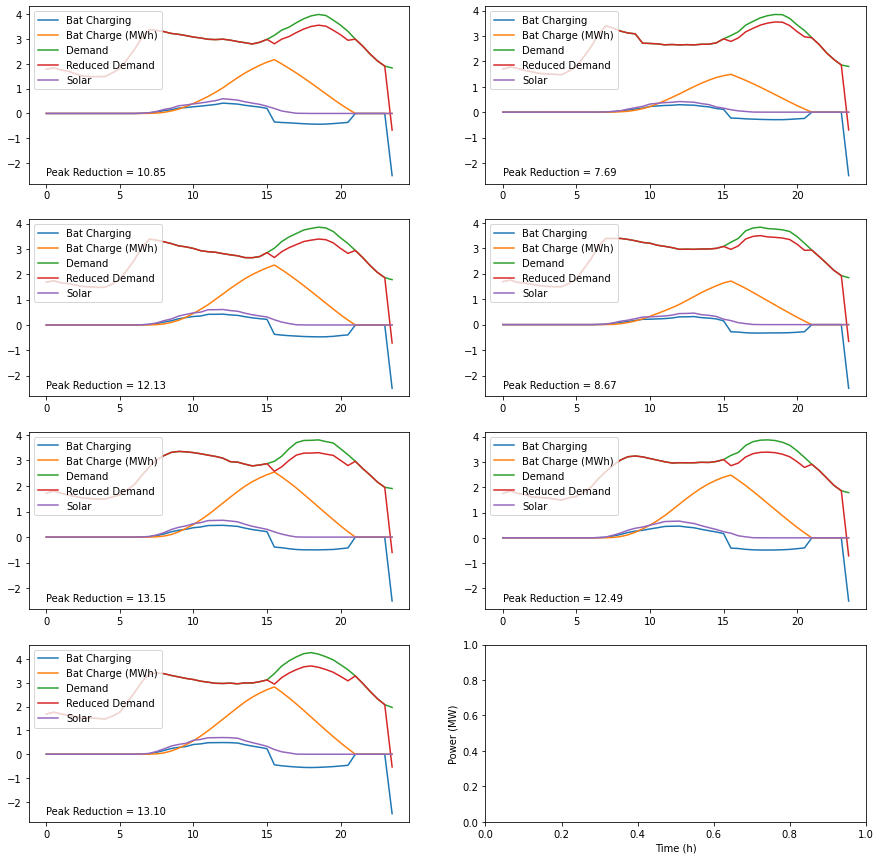

In [27]:
#%%%% Plot Results %%%%#

import matplotlib.pyplot as plt

fig, ax = plt.subplots(4,2)  # Create a figure that has one axes per day

plotcolumn=0
plotrow=0
for d in range(0,7):
    
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), B_day_results[d,:], label='Bat Charging')  # Plot Battery Charging (+ve charge, -ve discharge)
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), C_day_results[d,:], label='Bat Charge (MWh)')  # Plot Battery Charge level (this is the charge at the end of the given timestep)
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), DayDemand[d,:],label='Demand')  # Plot Demand forecast
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), ReducedDemand[d,:],label='Reduced Demand')  # Plot adjusted Demand
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), DaySolar[d,:],label='Solar')  # Plot Solar forecast


    ax[plotrow,plotcolumn].legend(loc='upper left')
    plt.xlabel("Time (h)")
    plt.ylabel("Power (MW)")

    Notation = "Peak Reduction = "+"{:.2f}".format(Day_Peak_Reduction[d])
    ax[plotrow,plotcolumn].annotate(Notation ,(0,min(B_day_results[d,:])))

    #if statements used to arrange the graphs correctly
    if d==1 or d==3 or d==5:
        plotrow += 1
    
    if plotcolumn==0:
        plotcolumn = 1
    else:
        plotcolumn = 0
       

fig.set_figheight(15)
fig.set_figwidth(15)       